In [ ]:
'''requirements
1. breakdown of the count of each item sold per month
2. breakdown of the total sale value per item per month
3. Table
    a. Repeaters - the number of customers from the current month who also purchased in the previous month. This metric is 0 for the earliest month in the transactional data.
    b. Inactive - the number of customers in the total set of transactions up to and including the current month who have purchase history but do not have a purchase for the current month. This metric is 0 for the earliest month in the transactional data.
    c. Engaged - the number of customers in the total set of transactions up to and including the current month who have consistently purchased every single month.
'''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import plotly.express as px
import datetime as dt
import seaborn as sns

In [3]:
#clean-up of data from granules from a granularity of one transaction per row to ans formed into a granularity of one “line item” per row.

#split items via each transaction into their own row 
with open ('transaction-data-adhoc-analysis.json') as text:
        data = json.load(text)
        df = pd.DataFrame(data) #result will be from a Dictionary to a DataFrame
        
df['transaction_items'] = df['transaction_items'].str.split(';')
df = df.explode('transaction_items').reset_index(drop=True)
cols = list(df.columns)
cols.append(cols.pop(cols.index('username')))
df = df[cols]
#source: https://thewebdev.info/2022/03/26/how-to-split-text-in-a-column-into-multiple-rows-with-python-pandas/


#split each item by its quantity in which a new column would be made for the quantity
df[["brand_name","product_name", "quantity"]] = df["transaction_items"].str.split(",",expand=True)
#source: https://www.delftstack.com/howto/python-pandas/split-column-in-python-pandas/

#convert the quantity (which is still a string) into an integer value
df["quantity"] = df["quantity"].str[:-1]
df["quantity"] = df["quantity"].str[-1:] #cutout the parentheses and 'x' to get the number only
df['quantity'] = df['quantity'].astype('int')
#source: https://sparkbyexamples.com/pandas/pandas-convert-column-to-int/#:~:text=2.-,Convert%20Column%20to%20int%20(Integer),int64%20%2C%20numpy.

#fix the transaction values by manually calculating the price of each item through the orders with only 1 product in it
#cannot find source on how to replace values in an existing column, hence I will make a new one -- https://datagy.io/pandas-conditional-column/
conditions = [(df['product_name'] == 'Beef Chicharon'),
              (df['product_name'] == 'Nutrional Milk'),
              (df['product_name'] == 'Orange Beans'),
              (df['product_name'] == 'Kimchi and Seaweed'),
              (df['product_name'] == 'Gummy Worms'),
              (df['product_name'] == 'Gummy Vitamins'),
              (df['product_name'] == 'Yummy Vegetables'),
             
]

values = [(df['quantity'] * 1299), 
          (df['quantity'] * 1990),
          (df['quantity'] * 199),
          (df['quantity'] * 799),
          (df['quantity'] * 150),
          (df['quantity'] * 1500),
          (df['quantity'] * 500),
    
]

df['total_sale_value'] = np.select(conditions, values) 

#delete old transaction value
del df['transaction_value']

#separate transaction date into month and year -- https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column
df['month'] = pd.DatetimeIndex(df['transaction_date']).month
df['year'] = pd.DatetimeIndex(df['transaction_date']).year
df['year_month'] = df['year'].astype(str) + '-'+ df['month'].astype(str) # https://datascientyst.com/extract-month-and-year-datetime-column-in-pandas/
del df['month']
del df['year']

In [10]:
#Requirement 1: breakdown of the count of each item sold per month
#Requirement 2: breakdown of the total sale value per item per month
product_quantity_sales = df.groupby(['year_month', 'product_name']).sum() # https://dataindependent.com/pandas/pandas-sum-pd-dataframe-sum/
product_quantity_sales

quantity  total_sale_value
year_month product_name                                  
2022-1     Beef Chicharon          9665          12554835
           Gummy Vitamins          9681          14521500
           Gummy Worms             9559           1433850
           Kimchi and Seaweed      9676           7731124
           Nutrional Milk          9727          19356730
           Orange Beans            9774           1945026
           Yummy Vegetables        9959           4979500
2022-2     Beef Chicharon         10001          12991299
           Gummy Vitamins          9980          14970000
           Gummy Worms             9996           1499400
           Kimchi and Seaweed      9949           7949251
           Nutrional Milk          9691          19285090
           Orange Beans           10037           1997363
           Yummy Vegetables       10256           5128000
2022-3     Beef Chicharon          9816          12750984
           Gummy Vitamins         10145          15217500
           Gummy Worms             9986           1497900
           Kimchi and Seaweed      9967           7963633
           Nutrional Milk          9876          19653240
           Orange Beans            9611           1912589
           Yummy Vegetables        9896           4948000
2022-4     Beef Chicharon          9890          12847110
           Gummy Vitamins          9842          14763000
           Gummy Worms            10043           1506450
           Kimchi and Seaweed      9921           7926879
           Nutrional Milk          9786          19474140
           Orange Beans            9914           1972886
           Yummy Vegetables        9861           4930500
2022-5     Beef Chicharon         10028          13026372
           Gummy Vitamins          9948          14922000
           Gummy Worms             9801           1470150
           Kimchi and Seaweed      9773           7808627
           Nutrional Milk          9881          19663190
           Orange Beans            9964           1982836
           Yummy Vegetables        9735           4867500
2022-6     Beef Chicharon          9902          12862698
           Gummy Vitamins          9980          14970000
           Gummy Worms             9934           1490100
           Kimchi and Seaweed     10104           8073096
           Nutrional Milk          9767          19436330
           Orange Beans           10106           2011094
           Yummy Vegetables        9722           4861000

In [ ]:
#we can use the table below to determine the repeaters, inactive, and engaged by using if the value per month per user is 0 or not
#when the user has a sum of 0 purchases, that means they did not purchase during the month, and if it is not equal to 0, that means they submitted

In [16]:
#make pivot table based on how many purchases customers did per month
#setting up for knowing whether customer purchased from a certain month 
user_purchase = pd.pivot_table(df, values = 'quantity', index = 'name', columns = 'year_month', fill_value = 0, aggfunc = 'sum')
user_purchase

year_month,2022-1,2022-2,2022-3,2022-4,2022-5,2022-6
name,,,,,,
Aaron Beasley,0,0,0,9,8,1
Aaron Brewer,4,6,1,9,0,13
Aaron Brown,0,0,20,14,8,1
Aaron Coffey,1,7,9,12,12,0
Aaron Davis,6,1,0,15,15,12
...,...,...,...,...,...,...
Zachary Valentine,7,6,3,2,14,19
Zachary Ware,6,9,16,5,10,8
Zachary Williams,24,23,19,14,0,0


Text(0.5, 1.0, 'Distribution of Sex for All Orders')

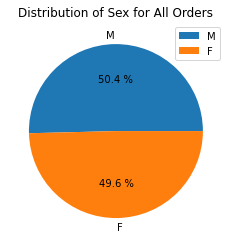

In [23]:
#insight 1 - https://stackoverflow.com/questions/66108871/how-to-create-a-pie-chart-from-a-text-column-data-only-using-pandas-dataframe-di
s = df['sex']
s.value_counts(normalize=True).plot.pie(autopct='%.1f %%', ylabel='', legend=True)
plt.title('Distribution of Sex for All Orders')

#We can see that there is no great difference between Males and Females through the number of their orders for DigiFood. 
#This can be insightful for marketing since they do not have to focus on either sex, but instead product materials that are catered for everyone. 

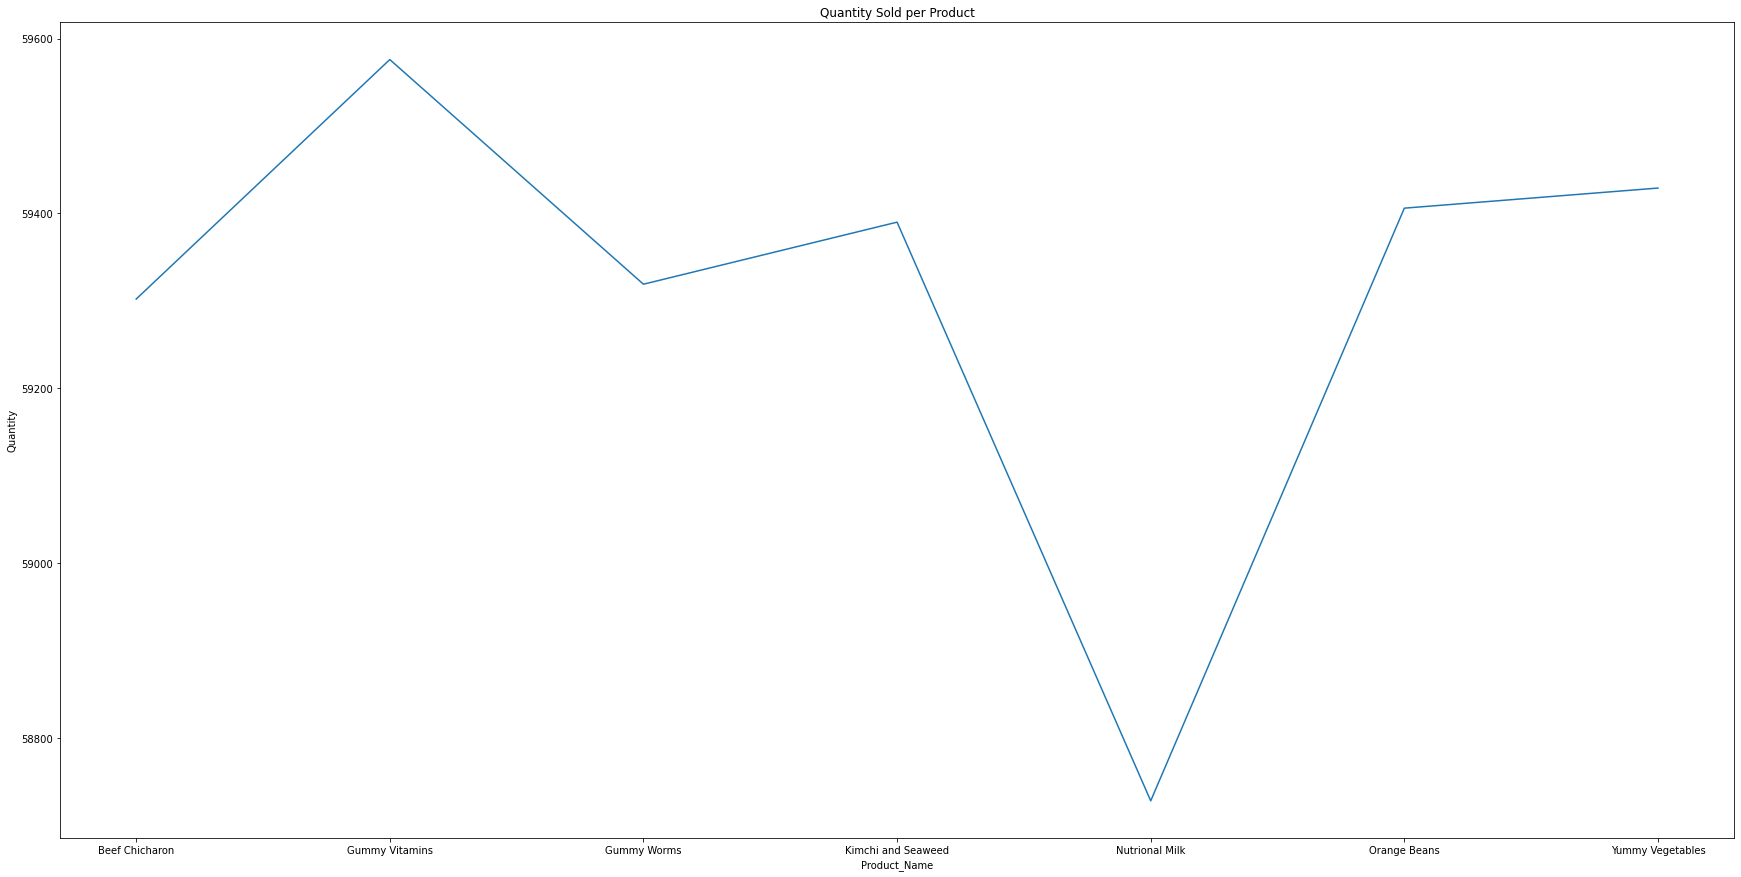

In [31]:
#Insight 2: Quantity sold per product
sales = product_quantity_sales.groupby(['product_name']).sum()
plt.figure(figsize=(30,15))
sales['quantity'].plot()
plt.xlabel('Product_Name')
plt.ylabel('Quantity')
plt.title('Quantity Sold per Product')
plt.show()

# We can see that DigiFoods best seller is gummy vitamins, while the least bought is nutritional milk. 
# This can be explained through people not necessarily needing nutritional milk (which in the real world is more catered to younger people, while gummy vitamins (though expensive) can be taken by anyone as suppliments 

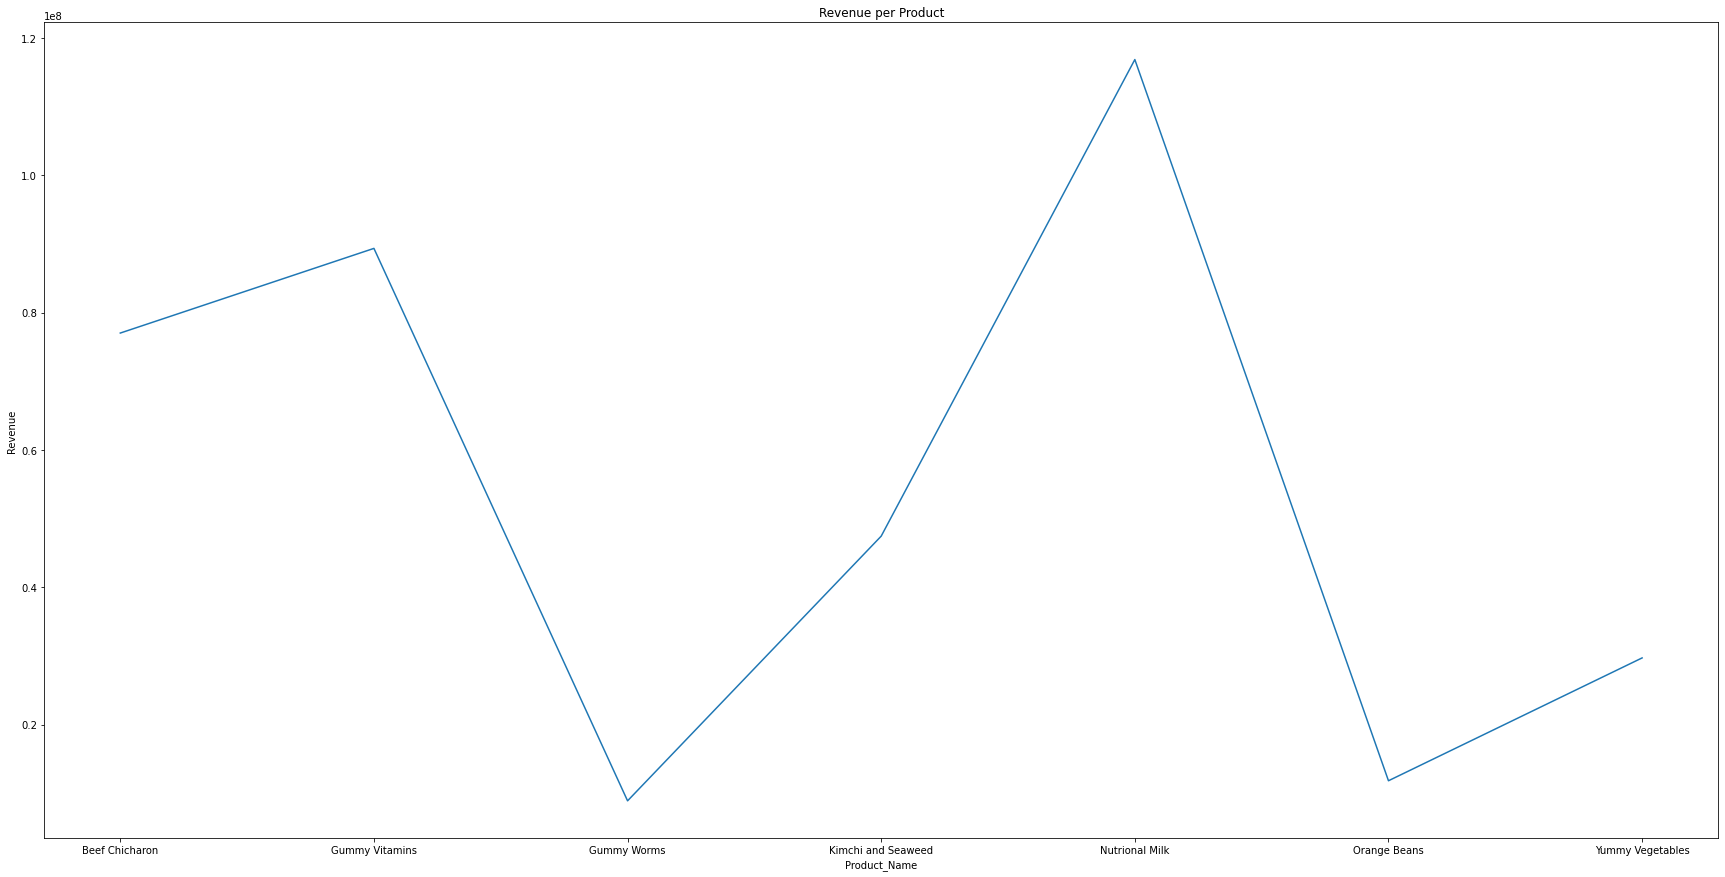

In [34]:
#Insight 3: Revenue per product
sales = product_quantity_sales.groupby(['product_name']).sum()
plt.figure(figsize=(30,15))
sales['total_sale_value'].plot()
plt.xlabel('Product_Name')
plt.ylabel('Revenue')
plt.title('Revenue per Product')
plt.show()

# Despite Nutritional Milk being sold the least, it brings the most revenue to the company. This may be attributed to it being the most expensive. 

In [ ]:
#UNFINISHED insight 4 - bar graph - https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#logic: grouped bar graph to compare each product quantity with each other per month
labels = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']
productname = product_quantity_sales['product_name']
quantity = product_quantity_sales['quantity']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, productname, width, label='Product Name')
rects2 = ax.bar(x + width/2, quantity, width, label='Quantity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [25]:
df

,address,birthdate,mail,name,sex,transaction_items,transaction_date,username,brand_name,product_name,quantity,total_sale_value,year_month
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,"Exotic Extras,Beef Chicharon,(x4)",2022/01/12,veronicawells,Exotic Extras,Beef Chicharon,4,5196,2022-1
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"Exotic Extras,Beef Chicharon,(x3)",2022/01/12,cgilbert,Exotic Extras,Beef Chicharon,3,3897,2022-1
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"HealthyKid 3+,Nutrional Milk,(x4)",2022/01/12,cgilbert,HealthyKid 3+,Nutrional Milk,4,7960,2022-1
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"Candy City,Orange Beans,(x1)",2022/01/12,cgilbert,Candy City,Orange Beans,1,199,2022-1
4,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,"HealthyKid 3+,Gummy Vitamins,(x3)",2022/01/08,cgilbert,HealthyKid 3+,Gummy Vitamins,3,4500,2022-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166114,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,"HealthyKid 3+,Nutrional Milk,(x2)",2022/06/09,llowe,HealthyKid 3+,Nutrional Milk,2,3980,2022-6
166115,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,"Candy City,Gummy Worms,(x2)",2022/06/09,llowe,Candy City,Gummy Worms,2,300,2022-6
166116,"PSC 1089, Box 3720\nAPO AE 08973",2012/04/30,xjones@hotmail.com,Stephanie Russell,F,"HealthyKid 3+,Nutrional Milk,(x1)",2022/06/03,cmcdowell,HealthyKid 3+,Nutrional Milk,1,1990,2022-6
166117,"PSC 1089, Box 3720\nAPO AE 08973",2012/04/30,xjones@hotmail.com,Stephanie Russell,F,"Candy City,Gummy Worms,(x3)",2022/06/03,cmcdowell,Candy City,Gummy Worms,3,450,2022-6
